# WD Database for Python

The goal is to download the following database: http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=J%2FMNRAS%2F455%2F3413 for use in a machine-learning inspired scheme to 

In [32]:
#Preamble. Standard packages for to load
import astropy
from astropy.table import Table, Column, MaskedColumn, vstack 
import numpy as np
from astroquery.vizier import Vizier
import matplotlib.pyplot as plt
import urllib2
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 
from astroquery.sdss import SDSS
from astropy import units as u
from astropy import coordinates as coords
from astropy.io import fits
import astropy.io.ascii as ascii
import scipy.optimize as op
import os
import random

In [2]:
catalog_list_1 = Vizier.find_catalogs('New white dwarf SDSS DR12')
catalog_list_2 = Vizier.find_catalogs('J/ApJS/204/5')
catalog_list_3 = Vizier.find_catalogs('J/MNRAS/446/4078')

In [3]:
print({k:v.description for k,v in catalog_list_1.items()})
print({k:v.description for k,v in catalog_list_2.items()})
print({k:v.description for k,v in catalog_list_3.items()})

{u'J/MNRAS/455/3413': u'New white dwarf and subdwarf stars in SDSS DR12 (Kepler+, 2016)'}
{u'J/ApJS/204/5': u'SDSS DR7 white dwarf catalog (Kleinman+, 2013)'}
{u'J/MNRAS/446/4078': u'New white dwarf stars in SDSS DR10 (Kepler+, 2015)'}


In [4]:
Vizier.ROW_LIMIT = -1
catalogs_1 = Vizier.get_catalogs(catalog_list_1.keys())
catalogs_2 = Vizier.get_catalogs(catalog_list_2.keys())
catalogs_3 = Vizier.get_catalogs(catalog_list_3.keys())

/Users/joshuapaultan/anaconda/lib/python2.7/site-packages/astroquery/vizier/core.py:683: UserWarning: VOTABLE parsing raised exception: None:336:189: ValueError: invalid literal for int() with base 10: 'null' (in row 147, col 'f_umag')
  warnings.warn("VOTABLE parsing raised exception: {0}".format(ex))


In [5]:
print(catalogs_1)
print(catalogs_2)
print(catalogs_3)

TableList with 1 tables:
	'0:J/MNRAS/455/3413/table6' with 34 column(s) and 6647 row(s) 
TableList with 1 tables:
	'0:J/ApJS/204/5/table2' with 45 column(s) and 20407 row(s) 
TableList with 1 tables:
	'0:J/MNRAS/446/4078/table6' with 30 column(s) and 9112 row(s) 


In [6]:
catalogs = vstack([catalogs_1[0], catalogs_2[0], catalogs_3[0]])

In [7]:
catalogs

_RAJ2000,_DEJ2000,PMF,SDSS,S_N,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,E_B-V_,pm,GLON,GLAT,SpType,Teff,e_Teff,logg,e_logg,Teff_3D_,e_Teff_3D_,logg_3D_,e_logg_3D_,Mass,e_Mass,Com,Sp,_RA.icrs,_DE.icrs,Plate,MJD,Fiber,RAJ2000,DEJ2000,SNg,f_umag,f_gmag,f_rmag,f_imag,f_zmag,f_pm,pmPA,Ag,GMT,Atype,log_g_,e_log_g_,chi2,m_Nsp,Nsp,q_Nsp,Type,WDcat,DR7,Sloan,Simbad,PMJ,_RA,_DE
deg,deg,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,0.01 / yr,deg,deg,,K,K,[cm/s2],[cm/s2],K,K,[cm/s2],[cm/s2],Msun,Msun,,,deg,deg,,d,,deg,deg,,,,,,,,deg,mag,"""datime""",,[cm/s2],[cm/s2],,,,,,,,,,,deg,deg
float64,float64,str15,str19,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str9,int32,int32,float32,float32,int32,int32,float32,float32,float64,float64,str69,str2,float64,float64,int16,int32,int16,float64,float64,float32,int64,int64,int64,int64,int64,uint8,float32,float32,str20,str14,float32,float32,float32,str4,int16,str1,str19,int16,str3,str5,str6,str15,float64,float64
192.84360,-2.67170,0337-51997-0195,125122.06-023737.21,22,18.12,0.02,17.57,0.02,17.55,0.01,17.57,0.02,17.60,0.02,0.021,5.10,302.9,60.2,sdB,29108,463,5.409,0.087,--,--,--,--,--,--,,Sp,192.8436,-2.6717,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
232.78030,55.01910,0614-53437-0049,153112.62+550139.60,22,17.61,0.01,17.83,0.02,18.32,0.02,18.67,0.02,18.96,0.04,0.018,8.30,88.1,49.9,sdB,29876,374,5.292,0.080,--,--,--,--,--,--,,Sp,232.7803,55.0191,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
221.71480,58.15350,0790-52346-0634,144657.14+580920.12,46,15.84,0.01,15.67,0.01,15.67,0.02,15.70,0.02,15.76,0.02,0.010,3.90,97.9,53.0,sdB,30893,165,5.033,0.032,--,--,--,--,--,--,,Sp,221.7148,58.1535,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
117.37760,28.08670,1059-52618-0515,074915.66+280641.01,11,18.91,0.02,19.10,0.03,19.52,0.02,19.86,0.03,20.15,0.11,0.035,4.60,192.5,24.3,sdB,29404,704,5.450,0.142,--,--,--,--,--,--,,Sp,117.3776,28.0867,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
326.60840,-7.21670,1177-52824-0636,214627.88-071117.59,45,16.16,0.01,15.94,0.03,15.86,0.01,15.86,0.01,15.90,0.02,0.035,7.00,48.6,-41.9,sdB,30503,191,5.019,0.036,--,--,--,--,--,--,,Sp,326.6084,-7.2167,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
63.90770,25.61750,1254-52972-0163,041536.05+253857.11,41,16.14,0.01,16.27,0.01,16.46,0.01,16.65,0.01,16.83,0.02,0.483,6.10,170.4,-17.9,He-sdO,64329,1429,6.118,0.073,--,--,--,--,--,--,,Sp,63.9077,25.6175,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
251.22790,21.59420,1569-53168-0370,164453.35+213711.54,20,17.75,0.02,17.82,0.01,18.22,0.01,18.55,0.01,18.81,0.04,0.050,3.00,40.5,37.0,sdB,26349,889,5.114,0.104,--,--,--,--,--,--,,Sp,251.2279,21.5942,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
244.92500,24.15590,1574-53476-0225,161942.83+240715.70,46,16.79,0.02,16.42,0.02,16.46,0.02,16.48,0.01,16.57,0.02,0.067,11.90,41.5,43.3,sdB,27741,342,5.227,0.048,--,--,--,--,--,--,,Sp,244.9250,24.1559,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--


In [8]:
#This is a way to add coordinates if we need to. I don't think we need to right now.
#catalogs['Coordinates'] = coords.SkyCoord(catalogs['_RAJ2000'], catalogs['_DEJ2000'], frame='icrs')

In [9]:
#Here we do clean-up trying to merge those columns which were not properly merged
#because they were named different things in different catalogs. These include
#SDSS identifiers, a weird underscore for a log(g) parameter, different ways of
#specifying spectral type, and different ways of calibrating signal to noise.

PMF = catalogs['PMF']

for ind,obj in enumerate(PMF):
    if type(obj) != np.ma.core.MaskedConstant:
        split_PMF = obj.split('-')
        catalogs['Plate'][ind] = split_PMF[0]
        catalogs['MJD'][ind] = split_PMF[1]
        catalogs['Fiber'][ind] = split_PMF[2]
        
PMJ = catalogs['PMJ']

for ind,obj in enumerate(PMJ):
    if type(obj) != np.ma.core.MaskedConstant:
        split_PMJ = obj.split('-')
        catalogs['Plate'][ind] = split_PMJ[0]
        catalogs['MJD'][ind] = split_PMJ[1]
        catalogs['Fiber'][ind] = split_PMJ[2]

log_g_ah = catalogs['log_g_']

for ind,obj in enumerate(log_g_ah):
    if type(catalogs['logg'][ind]) == np.ma.core.MaskedConstant:
        if type(obj) != np.ma.core.MaskedConstant:
            catalogs['logg'][ind] = obj
            catalogs['e_logg'][ind] = catalogs['e_log_g_'][ind] 

Types = catalogs['SpType']

for ind,obj in enumerate(Types):
    if type(catalogs['Type'][ind]) == np.ma.core.MaskedConstant:
        if type(obj) != np.ma.core.MaskedConstant:
            catalogs['Type'][ind] = obj
            
SN = catalogs['SNg']

for ind,obj in enumerate(SN):
    if type(catalogs['S_N'][ind]) == np.ma.core.MaskedConstant:
        if type(obj) != np.ma.core.MaskedConstant:
            catalogs['S_N'][ind] = obj

### Let's select a quality sample of WD spectra of Type DA

In [10]:
WD = catalogs[catalogs['Type'] == 'DA']

print("We start with", len(WD), "WDs")

# First, we want to remove systems with NaN's - only found in log g
good_WD = WD[np.where(~np.isnan(WD['logg']))]
print("We removed", len(WD[np.isnan(WD['logg'])]), "systems with NaNs")

# Now, we want to remove systems in which the log g was assumed. These all have e_logg=0.0
good_WD = good_WD[good_WD['e_logg'] != 0.0]
print("Number with determined log g",len(good_WD))

# Next, we only want objects with a S/N above 10
good_WD = good_WD[good_WD['S_N']>10]
print("Number with S/N > 10",len(good_WD))

# Next, we want objects with log g uncertainties smaller than, say, 0.2
good_WD = good_WD[good_WD['e_logg']<0.2]
print("Number with log g error less than 0.2",len(good_WD))

# # Let's do the same with T_eff uncertainties - limit to 15% of T_eff
# good_WD = good_WD[good_WD['e_Teff']<0.15*good_WD['Teff']]
# print("Number with Teff uncertainties less than 15%",len(good_WD))

# Print the median Teff error
print("Median T_eff error:", np.median(good_WD['e_Teff']))

# Print the median log g error
print("Median log g error:", np.median(good_WD['e_logg']))

('We start with', 21539, 'WDs')
('We removed', 0, 'systems with NaNs')
('Number with determined log g', 21505)
('Number with S/N > 10', 8746)
('Number with log g error less than 0.2', 8664)
('Median T_eff error:', 161.0)
('Median log g error:', 0.05299999937415123)


In [11]:
def download_data(cat):
    directory = '../data/'
    cat['file'] = MaskedColumn(length=len(cat),dtype='S32')
    for ind,plate in enumerate(cat['Plate']):
        filename = 'DA_high_SN_'+str(ind).zfill(5)+'.fits'
        if os.path.exists(directory+filename): 
            cat['file'][ind] = filename
            continue
        try:
            spec = SDSS.get_spectra(plate=plate, mjd=cat['MJD'][ind], fiberID=cat['Fiber'][ind])
            spec[0].writeto(directory+filename)
            cat['file'][ind] = filename
        except:
            print "Could not download spectra:", ind, plate, cat['MJD'][ind], cat['Fiber'][ind]
            pass  

In [12]:
download_data(good_WD)

Could not download spectra: 403 6686 56412 868
Could not download spectra: 721 1468 52999 181
Could not download spectra: 786 1135 53018 65
Could not download spectra: 860 396 51816 262
Could not download spectra: 874 2825 54439 480
Could not download spectra: 991 2865 54497 251
Could not download spectra: 994 2865 54497 420
Could not download spectra: 997 2865 54497 500
Could not download spectra: 1004 2865 54497 540
Could not download spectra: 1007 2865 54497 88
Could not download spectra: 1011 2865 54497 99
Could not download spectra: 1020 2865 54497 612
Could not download spectra: 1057 404 51812 131
Could not download spectra: 1058 404 51877 139
Could not download spectra: 1103 2636 54082 238
Could not download spectra: 1139 2399 53764 173
Could not download spectra: 1160 2444 54082 55
Could not download spectra: 1183 2398 53768 399
Could not download spectra: 1268 2417 53766 59
Could not download spectra: 1548 2713 54397 309
Could not download spectra: 1565 2713 54397 492
Could no

In [13]:
good_WD = good_WD[good_WD['file'] != ''] #removes failed downloads
print("Number of spectra downloaded:", len(good_WD))

('Number of spectra downloaded:', 8603)


In [35]:
def add_lorentz_columns(catalog):
    t2 = Table(np.arange(18*len(catalog)).reshape(len(catalog),18),
               masked=True,
               names=('C0', 'C1', 'C2', 'C3', 'C4', 'C5', 
                     'G0', 'G1', 'G2', 'G3', 'G4', 'G5',
                     'X0', 'X1', 'X2', 'X3', 'X4', 'X5'))
    t2.mask = True
    catalog.add_columns(t2.columns.values())

In [42]:
add_lorentz_columns(good_WD)

In [43]:
# Our model has a temperature effect, then absorption features on top of the model

# Constants
h_planck = 4.136e-15 # in eV*s
c_light = 2.998e10   # in cgs
k_boltz = 8.617e-5   # in eV/K


# Balmer line centers (in cgs):
lambda_balmer = np.array([6563, 4861, 4341, 4102, 3970, 3889])
window_dict = {}



# Lorentz distribution:
def lorentz(C_coeff, x_center, gamma, x):
    return -C_coeff / (np.pi * gamma * (1.0 + ((x-x_center)/gamma)**2))

#We must define our probability function in order to use emcee
def like(p, x, y):
    C_coeff, x_center, gamma = p
    model = lorentz(C_coeff, x_center, gamma, x)
    sigma = (model - y)**2
    return np.sum(sigma)

def my_line(points, x_vec):
    x_coords, y_coords = zip(*points)
    A = np.vstack([x_coords,np.ones(len(x_coords))]).T
    m, c = np.linalg.lstsq(A, y_coords)[0]
    return m*x_vec + c

def FWHM(height,norm):
    gam = 1/(np.pi*np.abs(height))
    return gam*norm



nll = lambda *args: -like(*args)

def spectrum_fit(lambda_balmer,all_lambda,all_flux,num):
    line = lambda_balmer[num]
    window = np.where(np.logical_and(all_lambda>= (line - 30), all_lambda<= (line + 30)))[0]

    #Get an educated guess for C_true
    thirds = len(all_flux[window])/3
    left_max = np.max(all_flux[window][:thirds])
    right_max = np.max(all_flux[window][-thirds:])
    left_point = all_lambda[window][:thirds][np.argmax(all_flux[window][:thirds])]
    right_point = all_lambda[window][2*thirds + np.argmax(all_flux[window][-thirds:])]

    points = [(left_point,left_max),(right_point,right_max)]
    vert_fix = my_line(points,all_lambda[window])
    int_y = all_flux[window]-vert_fix
    result = np.trapz(int_y)

    left_mean = np.mean(all_flux[window][:thirds])
    right_mean = np.mean(all_flux[window][-thirds:])
    left_lambda = np.mean(all_lambda[window][:thirds])
    right_lambda = np.mean(all_lambda[window][-thirds:])

    points = [(left_lambda,left_mean),(right_lambda,right_mean)]
    vert_shift = my_line(points,all_lambda[window])

    #Define initial guesses
    C_true = result*-1
    x_true = (all_lambda[window][0] + all_lambda[window[-1]])/2
    gamma_true = FWHM(np.min(all_flux[window]-vert_shift),C_true)
    print(gamma_true)

    result = op.minimize(nll, [C_true, x_true, gamma_true], args=(all_lambda[window],all_flux[window]))
    C_coeff_ls, x_center_ls, gamma_ls = result["x"]

    return C_coeff_ls, x_center_ls, gamma_ls, window, vert_fix, vert_shift



def obtain_lorentz_parameters(catalog):
    #Main loop
    C_coeff_ls = np.zeros(6)
    x_center_ls = np.zeros(6)
    gamma_ls = np.zeros(6)
    total = 1
    for index,i in enumerate(catalog):
        #Gets data from file
        directory = "../data/"
        filename = directory+catalog['file'][index]

        try:
            data = fits.getdata(filename, 1)
        except:
            print("Missing", filename)
            continue

        all_flux = data['flux']
        all_lambda = 10 ** data['loglam']

        total = total + 1
        if total%100 == 0:  print(total)

        for ind,line in enumerate(lambda_balmer):
            ctitle = 'C'+str(ind)
            xtitle = 'X'+str(ind)
            gtitle = 'G'+str(ind)
            #Make the windows for lorentzian fitting
            window = np.where(np.logical_and(all_lambda>= (line - 30), all_lambda<= (line + 30)))[0]
            #Get an educated guess for C_true
            if not all_flux[window].size:
                continue
            thirds = int(len(all_flux[window])/3)
            left_max = np.max(all_flux[window][:thirds])
            right_max = np.max(all_flux[window][-thirds:])
            left_point = all_lambda[window][:thirds][np.argmax(all_flux[window][:thirds])]
            right_point = all_lambda[window][2*thirds + np.argmax(all_flux[window][-thirds:])]

            points = [(left_point,left_max),(right_point,right_max)]
            vert_fix = my_line(points,all_lambda[window])
            int_y = all_flux[window]-vert_fix
            result = np.trapz(int_y)

            left_mean = np.mean(all_flux[window][:thirds])
            right_mean = np.mean(all_flux[window][-thirds:])
            left_lambda = np.mean(all_lambda[window][:thirds])
            right_lambda = np.mean(all_lambda[window][-thirds:])

            points = [(left_lambda,left_mean),(right_lambda,right_mean)]
            vert_shift = my_line(points,all_lambda[window])

            #Define initial guesses
            C_true = result*-1
            x_true = (all_lambda[window][0] + all_lambda[window[-1]])/2
            gamma_true = FWHM(np.min(all_flux[window]-vert_shift),C_true)
            #print gamma_true

            result = op.minimize(nll, [C_true, x_true, gamma_true], args=(all_lambda[window],all_flux[window]))
            C_coeff_ls[ind], x_center_ls[ind], gamma_ls[ind] = result["x"]

            catalog[ctitle][index] = C_coeff_ls[ind]
            catalog[xtitle][index] = x_center_ls[ind]
            catalog[gtitle][index] = gamma_ls[ind]

In [44]:
obtain_lorentz_parameters(good_WD)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500


MC1TEMDN=-0.00000000000000E+00 / sp1 mech median temp                            [astropy.io.fits.card]
MC1TBCB =-0.00000000000000E+00 / sp1 mech Temp_Blue_Cam_Bot                      [astropy.io.fits.card]
MC1THT  =-0.00000000000000E+00 / sp1 mech Temp_Hartmann_Top                      [astropy.io.fits.card]


1600
1700
1800
1900
2000
2100
2200
2300
2400


MC1TRCT =-0.00000000000000E+00 / sp1 mech Temp_Red_Cam_Top                       [astropy.io.fits.card]


2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400


MC1TRCB =-0.00000000000000E+00 / sp1 mech Temp_Red_Cam_Bot                       [astropy.io.fits.card]


4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600


In [121]:
good_WD.write('DA_with_LP.dat', format='ascii')

In [48]:
good_WD['Teff_3D_'].count()

2460

In [119]:
zz = MaskedColumn(np.arange(len(good_WD)), name='z', mask=True)

good_WD.add_column(zz)

In [115]:
def add_z_to_table(catalog):
    directory = "../data/"
    total = 0
    for ind,it in enumerate(catalog):
        filename=directory+it['file']
        data = fits.getdata(filename, 2)
        catalog['z'][ind] = data['z'][0]
        total = total + 1
        if total%1000 == 0:  print(total)

In [120]:
add_z_to_table(good_WD)

/Users/joshuapaultan/anaconda/lib/python2.7/site-packages/astropy/table/column.py:1095: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


In [30]:
def get_filename(plate,mjd,fiber,wd):
    try:
        plwd = wd[wd['Plate'] == plate]
        if len(plwd) == 0: raise Exception()
    except Exception:
        print 'No plate number'
        return ''
    try:
        mjwd = plwd[plwd['MJD'] == mjd]
        if len(mjwd) == 0: raise Exception()
    except Exception:
        print 'No mjd date'
        return ''
    try:
        fbwd = mjwd[mjwd['Fiber'] == fiber]
        if len(fbwd) == 0: raise Exception()
    except Exception:
        print 'No fiber number'
        return ''
    name = fbwd['file']
    return str(name[0])

In [39]:
def plot_spec(plate,mjd,fiber,wd):
    fits_spec = fits.open('../data/'+get_filename(plate,mjd,fiber,wd))
    wavelength = 10**fits_spec[1].data['loglam']
    flux = fits_spec[1].data['flux']
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    ax[0].plot(wavelength, flux)
    ax[1].plot(wavelength, flux)
    ax[1].set_xlim(3800, 4400)
    plt.show()

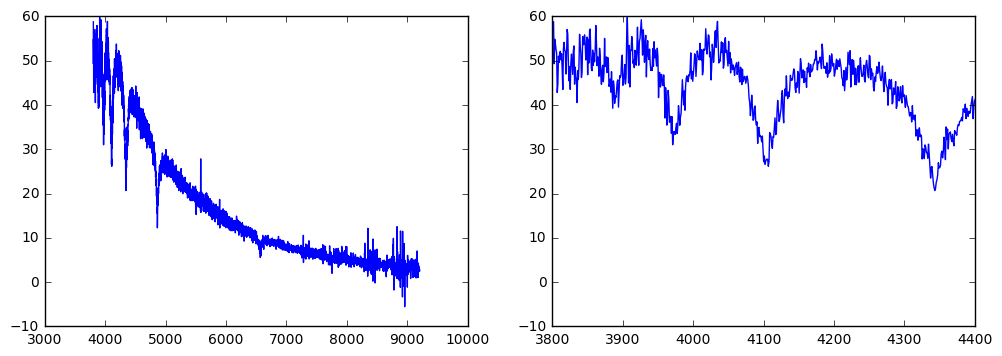

In [40]:
plot_spec(963,52643,527,good_WD)


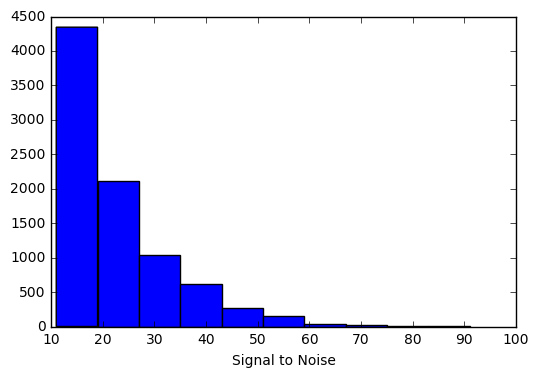

In [42]:
plt.hist(good_WD['S_N'])
plt.xlabel('Signal to Noise')

### Create training, test, and validation sets

In [ ]:
# Randomly shuffle indices
indices = np.arange(len(good_WD))
np.random.shuffle(indices)
good_shuffle_WD = good_WD[indices]

# Determine training, test, and validation sets
validation_WD = good_shuffle_WD[0:300]
test_WD = good_shuffle_WD[300:600]
training_WD = good_shuffle_WD[600:]

### Plot up systems in T_eff and log g space to see where they lie

In [ ]:
plt.errorbar(training_WD['logg'], training_WD['Teff'], xerr=training_WD['e_logg'], 
             yerr=training_WD['e_Teff'], ls='none', fmt='', capsize=0, label='train')

plt.errorbar(test_WD['logg'], test_WD['Teff'], xerr=test_WD['e_logg'], 
             yerr=test_WD['e_Teff'], ls='none', fmt='', capsize=0, label='test')

plt.errorbar(validation_WD['logg'], validation_WD['Teff'], xerr=validation_WD['e_logg'], 
             yerr=validation_WD['e_Teff'], ls='none', fmt='', capsize=0, label='val')
plt.legend()


plt.ylabel(r'T$_{\rm eff}$')
plt.xlabel(r'Log $g$')

plt.yscale('log')
plt.ylim(5.0e3, 1.0e5)

plt.show()

Now we will look at just the DAs.

In [ ]:
set(good_WD['SpType'])

In [43]:
DA_good = good_WD

print("Number of DAs in sample",len(DA_good))

('Number of DAs in sample', 8603)


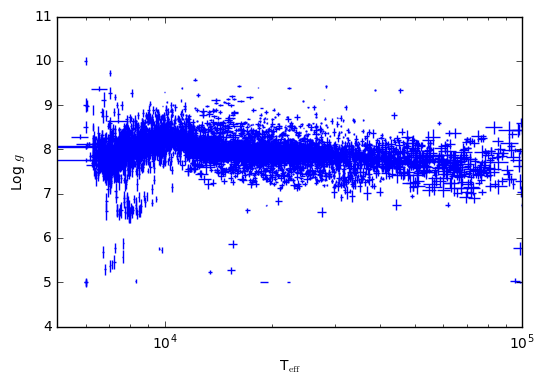

In [44]:
plt.errorbar(DA_good['Teff'], DA_good['logg'],yerr=DA_good['e_logg'], 
             xerr=DA_good['e_Teff'], ls='none', fmt='', capsize=0)


plt.xlabel(r'T$_{\rm eff}$')
plt.ylabel(r'Log $g$')

plt.xscale('log')
plt.xlim(5.0e3, 1.0e5)

plt.show()

/Users/joshuapaultan/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:4144: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")
/Users/joshuapaultan/anaconda/lib/python2.7/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


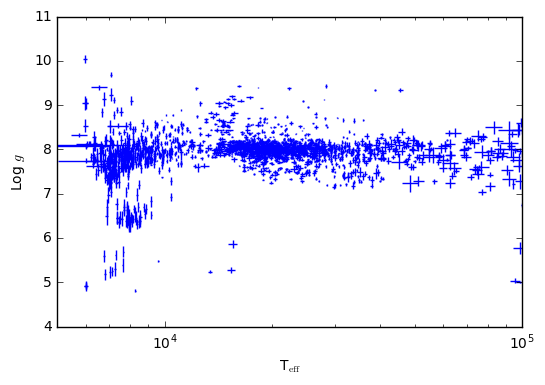

In [50]:
plt.errorbar(good_WD['Teff_3D_'], good_WD['logg_3D_'],yerr=good_WD['e_logg_3D_'], 
             xerr=good_WD['e_Teff_3D_'], ls='none', fmt='', capsize=0)


plt.xlabel(r'T$_{\rm eff}$')
plt.ylabel(r'Log $g$')

plt.xscale('log')
plt.xlim(5.0e3, 1.0e5)

plt.show()

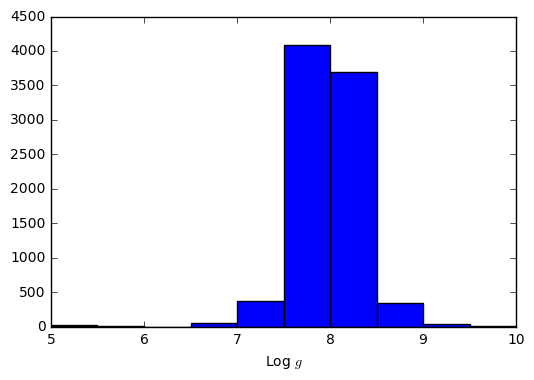

In [45]:
plt.hist(good_WD['logg'])
plt.xlabel(r'Log $g$')

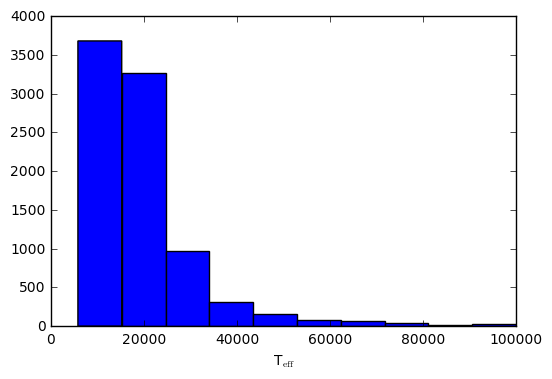

In [46]:
plt.hist(good_WD['Teff'])
plt.xlabel(r'T$_{\rm eff}$')

In [ ]:
ascii.write(DA_good, 'DA_good.csv', format='csv', include_names=['_RAJ2000','_DEJ2000','SDSS','S_N','umag','e_umag','gmag','e_gmag','rmag','e_rmag','imag','e_imag','zmag','e_zmag','E_B-V_','pm'])

In [ ]:
ind = []
for num,thing in enumerate(good_WD['SpType']):
    if 'A' in thing:
        ind += [num]

All_A = good_WD[ind]
print("Number of As in sample",len(All_A))

In [ ]:
All_A

In [ ]:
plt.errorbar(All_A['Teff'], All_A['logg'],yerr=All_A['e_logg'], 
             xerr=All_A['e_Teff'], ls='none', fmt='', capsize=0, color='red')


plt.xlabel(r'T$_{\rm eff}$')
plt.ylabel(r'Log $g$')

plt.xscale('log')
plt.xlim(5.0e3, 1.0e5)

plt.show()